**AI & Machine Learning (KAN-CINTO4003U) - Copenhagen Business School | Spring 2025**

***


# Part I: Bag-of-Words Model

Please see the description of the assignment in the README file (section 1) <br>
**Guide notebook**: [guides/bow_guide.ipynb](guides/bow_guide.ipynb)


***

<br>

* Note that you should report results using a classification report. 

* Also, remember to include some reflections on your results: Are there any hyperparameters that are particularly important?

* You should follow the steps given in the `bow_guide` notebook

<br>

***

In [116]:
# imports for the project

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from collections import Counter


### 1. Load the data

We can load this data directly from [Hugging Face Datasets](https://huggingface.co/docs/datasets/) - The HuggingFace Hub- into a Pandas DataFrame. Pretty neat!

**Note**: This cell will download the dataset and keep it in memory. If you run this cell multiple times, it will download the dataset multiple times.

You are welcome to increase the `frac` parameter to load more data.

In [117]:

splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}

train = pd.read_parquet("hf://datasets/fancyzhx/ag_news/" + splits["train"])
test = pd.read_parquet("hf://datasets/fancyzhx/ag_news/" + splits["test"])

print(train.shape, test.shape)

(120000, 2) (7600, 2)


In [118]:

label_map = {
    0: 'World',
    1: 'Sports',
    2: 'Business',
    3: 'Sci/Tech'
}

def preprocess(df: pd.DataFrame, frac : float = 1e-2, label_map : dict[int, str] = label_map, seed : int = 42) -> pd.DataFrame:
    """ Preprocess the dataset 

    Operations:
    - Map the label to the corresponding category
    - Filter out the labels not in the label_map
    - Sample a fraction of the dataset (stratified by label)

    Args:
    - df (pd.DataFrame): The dataset to preprocess
    - frac (float): The fraction of the dataset to sample in each category
    - label_map (dict): A mapping of the original label to the new label
    - seed (int): The random seed for reproducibility

    Returns:
    - pd.DataFrame: The preprocessed dataset
    """

    return  (
        df
        .assign(label=lambda x: x['label'].map(label_map))
        [lambda df: df['label'].isin(label_map.values())]
        .groupby('label')[["text", "label"]]
        .apply(lambda x: x.sample(frac=frac, random_state=seed))
        .reset_index(drop=True)

    )

train_df = preprocess(train, frac=0.01)
test_df = preprocess(test, frac=0.1)

# clear up some memory by deleting the original dataframes
del train
del test

train_df.shape, test_df.shape

((1200, 2), (760, 2))

2. Split the data

In [119]:
(
    
    X_train,
    X_val,
    y_train,
    y_val

) = train_test_split(train_df["text"], train_df["label"], test_size=0.2, random_state=42)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(960,) (240,) (960,) (240,)


3. Build the BoW Model

In [120]:
# Remove stop words, numbers, and items with less than 3 characters and create the document-term matrix
cv = CountVectorizer(
    stop_words='english', 
    min_df=5, 
    max_df=0.8, 
    ngram_range=(1, 2), 
    lowercase=True, 
    token_pattern=r'\b[a-zA-Z]{3,}\b',
    strip_accents='unicode', 
    analyzer='word',

)
X_train_vectorized = cv.fit_transform(X_train)

4. Visualizations after applying CountVectorizer and testing

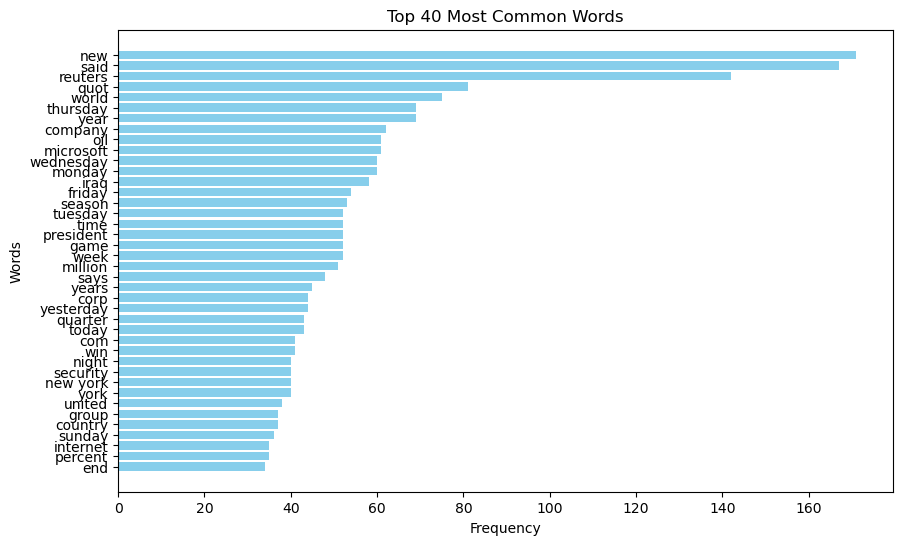

In [121]:
# Visualize the top N tokens
def visualize_top_n_tokens(word_freq, n=40):
    # Sort the DataFrame by count in descending order and select the top N words
    top_n_words = word_freq.sort_values(by='count', ascending=False).head(n)

    # Create the bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(top_n_words['word'], top_n_words['count'], color='skyblue')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.title(f'Top {n} Most Common Words')
    plt.gca().invert_yaxis()  # Invert y-axis to show the highest frequency at the top
    plt.show()

# Call the function with the word_freq DataFrame
visualize_top_n_tokens(word_freq, n=40)

Test: Print most common names

In [123]:
# Sum the occurrences of each word across all documents
word_counts = np.asarray(X_train_vectorized.sum(axis=0)).flatten()

# Create a DataFrame with words and their corresponding counts
word_freq = pd.DataFrame({'word': cv.get_feature_names_out(), 'count': word_counts})

# Sort the DataFrame by count in descending order and display the top 10 words
top_10_words = word_freq.sort_values(by='count', ascending=False).head(10)
print(top_10_words)

          word  count
589        new    171
759       said    167
739    reuters    142
703       quot     81
974      world     75
889   thursday     69
985       year     69
174    company     62
612        oil     61
540  microsoft     61


Test the word counting

In [ ]:
word = "new"
if word in cv.get_feature_names_out():
    print(f"The word {word} is in the vocabulary.")
else:
    print(f"The word {word} is not in the vocabulary.")

the_index = cv.get_feature_names_out().tolist().index(word)
the_count = word_counts[the_index]
print(f"The word {word} occurred {the_count} times in the training set.")
# Ensure that the word "the" is in the vocabulary
if word in cv.get_feature_names_out():
    print(f"The word {word} is in the vocabulary.")
else:
    print(f"The word {word} is not in the vocabulary.")

# Get the index of the word "the" in the vocabulary
the_index = cv.get_feature_names_out().tolist().index(word)

# Use this index to find the count of the word "the" in the word_counts array
the_count = word_counts[the_index]
print(f"The word {word} occurred {the_count} times in the training set.")

In [122]:
X_train_vectorized.todense()
#cv.vocabulary_

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

4. Create classifier

In [124]:
# Initialize the logistic regression classifier
lr_clf = LogisticRegression(max_iter=1000, C=1.0, solver='liblinear', random_state=42, class_weight='balanced')

lr_clf.fit(X_train_vectorized, y_train)
# Predict on the validation set
X_val_vectorized = cv.transform(X_val)
X_test_vectorized = cv.transform(test_df["text"])


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='liblinear')

In [150]:
# Initialize the Multinomial Naive Bayes classifier
nb_clf = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)
# Fit the model on the training data
nb_clf.fit(X_train_vectorized, y_train)

MultinomialNB()

In [151]:
# Transform validation and test data
X_val_vectorized = cv.transform(X_val)
X_test_vectorized = cv.transform(test_df["text"])

5. Get predictions and evaluate the model

In [152]:
# Predict on training, validation, and test sets for Logistic Regression
y_train_pred_lr = lr_clf.predict(X_train_vectorized)
y_val_pred_lr = lr_clf.predict(X_val_vectorized)
y_test_pred_lr = lr_clf.predict(X_test_vectorized)

# Predict on training, validation, and test sets for MultinomialNB
y_train_pred_nb = nb_clf.predict(X_train_vectorized)
y_val_pred_nb = nb_clf.predict(X_val_vectorized)
y_test_pred_nb = nb_clf.predict(X_test_vectorized)

# Calculate accuracy scores
train_accuracy_lr = accuracy_score(y_train, y_train_pred_lr)
val_accuracy_lr = accuracy_score(y_val, y_val_pred_lr)
test_accuracy_lr = accuracy_score(test_df["label"], y_test_pred_lr)

train_accuracy_nb = accuracy_score(y_train, y_train_pred_nb)
val_accuracy_nb = accuracy_score(y_val, y_val_pred_nb)
test_accuracy_nb = accuracy_score(test_df["label"], y_test_pred_nb)

# Print classification reports for the test set
print("Logistic Regression - Test Performance:")
print(classification_report(test_df["label"], y_test_pred_lr, target_names=label_map.values()))

print("MultinomialNB - Test Performance:")
print(classification_report(test_df["label"], y_test_pred_nb, target_names=label_map.values()))

# Create a DataFrame to compare accuracy scores
comparison_df = pd.DataFrame({
    "Model": ["Logistic Regression", "MultinomialNB"],
    "Training Accuracy": [train_accuracy_lr, train_accuracy_nb],
    "Validation Accuracy": [val_accuracy_lr, val_accuracy_nb],
    "Test Accuracy": [test_accuracy_lr, test_accuracy_nb]
})

# Display the comparison
print("\nAccuracy Comparison:")
print(comparison_df)

Logistic Regression - Test Performance:
              precision    recall  f1-score   support

       World       0.74      0.72      0.73       190
      Sports       0.78      0.72      0.75       190
    Business       0.84      0.86      0.85       190
    Sci/Tech       0.77      0.84      0.81       190

    accuracy                           0.78       760
   macro avg       0.78      0.78      0.78       760
weighted avg       0.78      0.78      0.78       760

MultinomialNB - Test Performance:
              precision    recall  f1-score   support

       World       0.80      0.73      0.76       190
      Sports       0.78      0.76      0.77       190
    Business       0.86      0.87      0.86       190
    Sci/Tech       0.80      0.88      0.84       190

    accuracy                           0.81       760
   macro avg       0.81      0.81      0.81       760
weighted avg       0.81      0.81      0.81       760


Accuracy Comparison:
                 Model  Training A

Multinomial NB classifier is better suited for Bag of Words model. It is inherently designed for classification tasks so it directly models the probability distribution of word counts. In our example we see that it is outperforming the LinearRegression and its test accuracy is 81% (vs the 78% on LR)

Confusion Matrix

In [156]:
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd

# Compute the confusion matrix
conf_matrix = confusion_matrix(test_df["label"], y_test_pred_nb)

# Define label map
label_map = {
    0: 'World',
    1: 'Sports',
    2: 'Business',
    3: 'Sci/Tech'
}

# Convert the confusion matrix to a DataFrame with descriptive headers
conf_matrix_df = pd.DataFrame(
    conf_matrix,
    index=[f"{label}" for label in label_map.values()],
    columns=[f"{label}" for label in label_map.values()]
)

# Calculate overall test accuracy
overall_accuracy = accuracy_score(test_df["label"], y_test_pred_nb)

# Calculate per-class accuracy
per_class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix_df)

# Display overall accuracy
print(f"\nOverall Test Accuracy: {overall_accuracy:.2f}")

# Display per-class metrics
print("\nPer-Class Metrics:")
for label, precision, recall, accuracy in zip(label_map.values(), per_class_precision, per_class_recall, per_class_accuracy):
    print(f"{label}: Precision: {precision:.2f}, Recall: {recall:.2f}, Accuracy: {accuracy:.2f}")
    



Confusion Matrix:
          World  Sports  Business  Sci/Tech
World       138      28         8        16
Sports       21     145        12        12
Business      3       9       165        13
Sci/Tech     11       5         7       167

Overall Test Accuracy: 0.81

Per-Class Metrics:
World: Precision: 0.80, Recall: 0.73, Accuracy: 0.73
Sports: Precision: 0.78, Recall: 0.76, Accuracy: 0.76
Business: Precision: 0.86, Recall: 0.87, Accuracy: 0.87
Sci/Tech: Precision: 0.80, Recall: 0.88, Accuracy: 0.88


Basic observations: 
1. "World" lable has been classified with the lowest accuracy of 73% - a significant portion of "World" articles are misclassified as other categories—especially as "Sports" (28 instances) and "Sci/Tech" (16 instances)

2. "Sports" 21 "Sports" articles were misclassified as "World." Most likely because the model associates the terminology with global news.

3. "Business" articles are classified most accurately, which likely means that the vocabulary and features used in these articles are distinctive.

4. "Sci/Tech" articles also show balanced performance, although there is some confusion with "World" (11 instances) and "Business" (7 instances). This could be due to overlap in terminology, especially in articles covering technological advancements with global or business implications.